#**APRIORI**




#**Bussiness goal**
O objetivo de negócio é identificar padrões de associação entre as características das propriedades, como número de quartos, casas de banho, localização, e a categoria de preço. Isso visa melhorar a compreensão das relações entre essas variáveis, otimizando a previsão do preço das casas e auxiliando na tomada de decisões para compradores, vendedores e investidores no mercado imobiliário.

#**Referencia do dataset utilizado**
O dataset utilizado está presente no seguinte link: https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data

#**Inicialização**

##**Importação de bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from google.colab import files

##**Importação do dataset**

In [2]:
import kagglehub

dataset_path = "muhammadbinimran/housing-price-prediction-data"
!kaggle datasets download {dataset_path} -p /content/ --unzip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset URL: https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data
License(s): other
  0% 0.00/763k [00:00<?, ?B/s]
100% 763k/763k [00:00<00:00, 57.5MB/s]


##**Demonstração do conteudo do dataset**

In [3]:
housing_price_file = pd.read_csv('housing_price_dataset.csv')
housing_price_data = pd.DataFrame(housing_price_file)

housing_price_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


##**Dataset metadata**

| Coluna        | Tipo de Dado |
|---------------|--------------|
| SquareFeet    | int          |
| Bedrooms      | int          |
| Bathrooms     | int          |
| Neighborhood  | string       |
| YearBuilt     | int          |
| Price         | float        |


#**Data preparation e data selection**


##**Verificação de nulos**

In [4]:
housing_price_data.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
SquareFeet,0
Bedrooms,0
Bathrooms,0
Neighborhood,0
YearBuilt,0
Price,0


Não existe valores nulos

##**Verificação de duplicatas**

In [4]:
housing_price_data.duplicated().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Não existe valores duplicados

##**Verificação dos valores**

Precisamos de verificar se existem valores que não fazem sentido no nosso contexto. Como por exemplo, a existencia de valores negativos.

In [5]:
numeric_columns = housing_price_data.select_dtypes(include=['number'])
negative_values = (numeric_columns < 0).sum()
print(negative_values)

SquareFeet     0
Bedrooms       0
Bathrooms      0
YearBuilt      0
Price         22
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Como existe preços negativos, temos de os tirar, pois nao faz sentido uma casa com valor negativo.

In [6]:
print(housing_price_data[housing_price_data['Price'] < 0].tail())
housing_price_data = housing_price_data[housing_price_data['Price'] >= 0].copy()
print("\nNegativos retirados...\n")
print(housing_price_data[housing_price_data['Price'] < 0].sum())

       SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt         Price
29827        1173         5          2        Rural       1988   -847.895073
30171        1066         3          1        Rural       1964   -602.209099
33666        1013         5          2        Urban       1960 -36588.165397
35553        1374         4          3        Urban       1996  -4771.570194
36929        1078         5          1       Suburb       2015  -6159.039213

Negativos retirados...

SquareFeet        0
Bedrooms          0
Bathrooms         0
Neighborhood      0
YearBuilt         0
Price           0.0
dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##**Criação das categorias**

Para a classificação das casas, foi seleciona o uso de 3 classes perante o preço. Classe **Baixa**, abaixo ou igual a 60000, classe **Média**, entre 60000 e 400000, e classe **Alta**, acima de 400000.

In [7]:
#criar categorias de preço
housing_price_data.loc[housing_price_data['Price'] <= 60000, 'PriceCategory'] = 'Baixo'
housing_price_data.loc[(housing_price_data['Price'] > 60000) & (housing_price_data['Price'] <= 400000), 'PriceCategory'] = 'Médio'
housing_price_data.loc[housing_price_data['Price'] > 400000, 'PriceCategory'] = 'Alto'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#**EDA Visualização**

##**Matriz de correlação**
A matriz de correlação é uma ferramenta estatística que mede a relação entre diferentes variáveis. Ela exibe valores entre -1 e 1, onde 1 significa uma correlação positiva perfeita, -1 uma correlação negativa perfeita e 0 indica nenhuma correlação. Essa matriz é útil para entender como as variáveis estão interligadas, ajudando a identificar padrões e a selecionar as variáveis mais relevantes.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


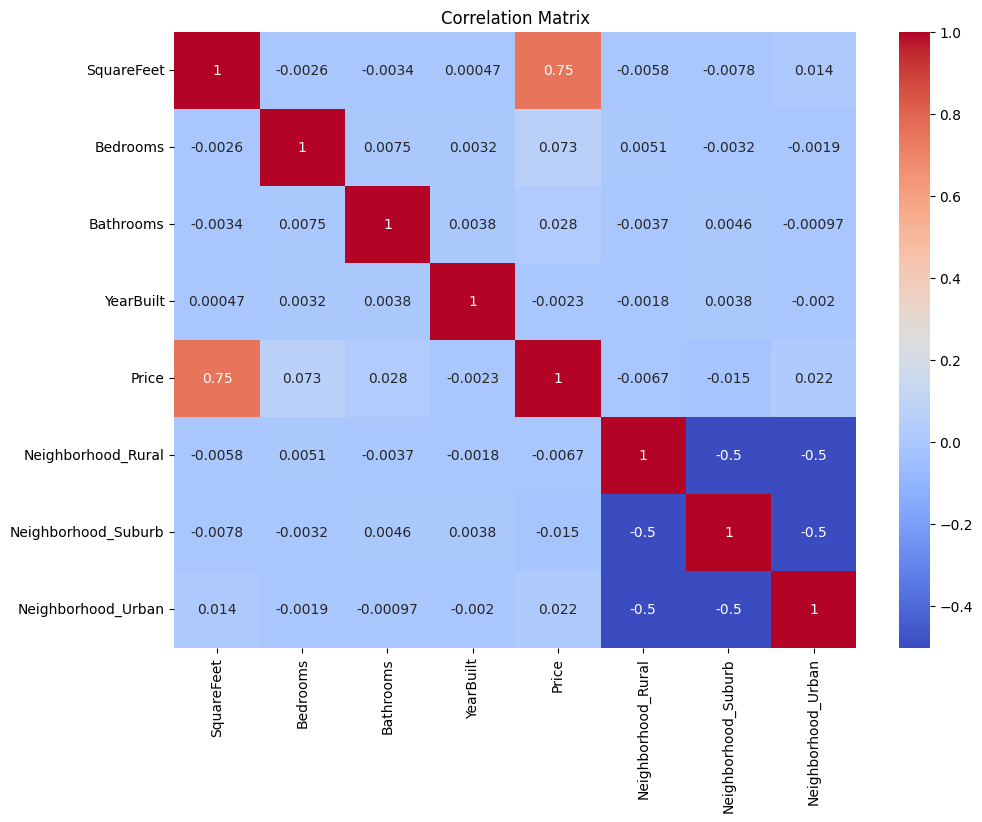

In [8]:
plt.figure(figsize=(11, 8))

housing_price_data =  pd.get_dummies(housing_price_data, columns=['Neighborhood'])
housing_price_correlation = housing_price_data.drop(columns=['PriceCategory'])

sns.heatmap(housing_price_correlation.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Com esta matriz, podemos ver que perante o **Price**, a *feature* utilizada para classe, o **Squarefeet** tem relação forte e os restantes tem relação muito fraca.

##**Diagrama de caixa**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


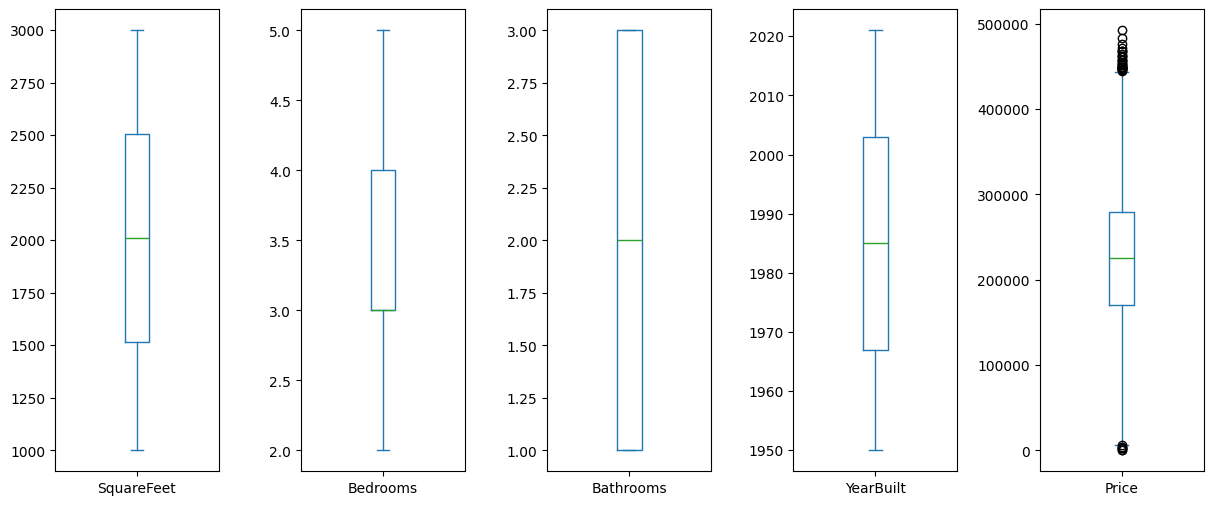

In [9]:
housing_price_data.plot(kind='box', subplots=True, layout=(1, 6), sharex=False, sharey=False, figsize=(18, 6))
plt.subplots_adjust(wspace=0.5)
plt.show()

Os diagramas de caixa mostram que a maioria das casas possui entre 1500 e 2500 pés quadrados, com uma mediana em torno de 2000. O número de quartos geralmente varia de 3 a 4, e a maior parte das propriedades tem 2 banheiros. As casas foram construídas principalmente entre 1970 e 2000, com uma mediana em 1985. O preço das casas apresenta uma distribuição assimétrica, com alguns *outliers* elevados, mas a maior concentração de preços está entre 175.000 e 275.000 unidades monetárias.

##**Remoção do Price**

Removemos o **Price** dos dados.

In [10]:
if 'Price' in housing_price_data.columns:
    housing_price_data = housing_price_data.drop(columns=['Price'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##**Peso das classes**

In [11]:
print(housing_price_data['PriceCategory'].value_counts())

PriceCategory
Médio    49105
Baixo      534
Alto       339
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


A classe **Média** tem um número maior que os outros, o que gera um desbalanceamento entre classes, o que poderá levar aos modelos classificarem mais vezes **Médio** do que deviam.

In [12]:

medium_class = housing_price_data[housing_price_data['PriceCategory'] == 'Médio']
other_classes = housing_price_data[housing_price_data['PriceCategory'] != 'Médio']

medium_class_reduced = medium_class.sample(frac=0.01, random_state=27)

housing_price_data = pd.concat([medium_class_reduced, other_classes])

housing_price_data = housing_price_data.sample(frac=1, random_state=27).reset_index(drop=True)

print(housing_price_data['PriceCategory'].value_counts())

PriceCategory
Baixo    534
Médio    491
Alto     339
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Agora as classes estão equilibradas.

##**Visualização 2D dos dados**

In [13]:
#sns.pairplot(housing_price_data, hue='PriceCategory')
#plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#**Implementação**

##**Agrupamento dos dados**

Nesta etapa, realizamos o agrupamento dos dados com base nas colunas 'Bedrooms', 'Bathrooms' e 'PriceCategory', além das colunas de bairro ('Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban'). O objetivo desse agrupamento é organizar as propriedades em grupos distintos, permitindo analisar como características como o número de quartos, banheiros e a categoria de preço estão distribuídas entre as diferentes regiões e bairros.

In [14]:
# Primeiro, agrupe os dados por 'Bedrooms', 'Bathrooms', 'PriceCategory' e as colunas de bairro
ds_grouped = housing_price_data.groupby(
    ['Bedrooms', 'Bathrooms', 'PriceCategory'], as_index=False
).agg({'SquareFeet': 'count'})  # Ou use qualquer coluna numérica, como 'SquareFeet'

# Verifique o número de valores únicos para as colunas relevantes
print("Bedrooms:  ", housing_price_data['Bedrooms'].nunique())
print("Bathrooms:  ", housing_price_data['Bathrooms'].nunique())
print("PriceCategory: ", housing_price_data['PriceCategory'].nunique())
print("Neighborhood columns: ", housing_price_data[['Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban']].nunique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bedrooms:   4
Bathrooms:   3
PriceCategory:  3
Neighborhood columns:  Neighborhood_Rural     2
Neighborhood_Suburb    2
Neighborhood_Urban     2
dtype: int64


##**Pivot table**

Criamos uma tabela dinâmica (pivot_table) para reorganizar os dados, agrupando por 'Bedrooms' e 'Bathrooms', e classificando por 'PriceCategory'. Usamos a soma de 'SquareFeet' para representar o número de ocorrências, preenchendo valores ausentes com zero. Depois, adicionamos as colunas de bairro ('Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban') à tabela dinâmica, combinando as informações em um formato mais completo para análise.

In [15]:
pivot_table = pd.pivot_table(
    ds_grouped,
    index=['Bedrooms', 'Bathrooms'],  # Combinações de número de quartos e banheiros
    columns=['PriceCategory'],  # Categoria de preço
    values='SquareFeet',  # Ou qualquer coluna numérica para representar a quantidade
    aggfunc='sum',  # Soma das ocorrências
    fill_value=0  # Preenche com 0 onde não há ocorrências
)

pivot_table = pivot_table.reset_index()
pivot_table = pd.concat([pivot_table, housing_price_data[['Neighborhood_Rural', 'Neighborhood_Suburb', 'Neighborhood_Urban']].iloc[ds_grouped.index].reset_index(drop=True)], axis=1) # adição dos neighborhood

print(pivot_table.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Bedrooms  Bathrooms  Alto  Baixo  Médio  Neighborhood_Rural  \
0       2.0        1.0  19.0   68.0   36.0               False   
1       2.0        2.0  23.0   58.0   39.0                True   
2       2.0        3.0  28.0   56.0   39.0               False   
3       3.0        1.0  23.0   51.0   49.0               False   
4       3.0        2.0  32.0   39.0   41.0                True   

   Neighborhood_Suburb  Neighborhood_Urban  
0                 True               False  
1                False               False  
2                False                True  
3                 True               False  
4                False               False  


##**Binary pivot table**

Nesta etapa, criamos uma cópia da pivot_table e aplicamos uma transformação para binarizar os valores. Todos os valores maiores que zero foram convertidos para 1, enquanto os valores zero foram convertidos para 0. Isso cria uma tabela binária que indica a presença (1) ou ausência (0) de determinados valores nas combinações de 'Bedrooms', 'Bathrooms' e 'PriceCategory', facilitando análises posteriores como algoritmos de aprendizado de máquina.

In [16]:
pivot_table_bin = pivot_table.copy()
pivot_table_bin = (pivot_table_bin > 0).astype(int)

# Exibindo a tabela binarizada
print(pivot_table_bin.head())

   Bedrooms  Bathrooms  Alto  Baixo  Médio  Neighborhood_Rural  \
0         1          1     1      1      1                   0   
1         1          1     1      1      1                   1   
2         1          1     1      1      1                   0   
3         1          1     1      1      1                   0   
4         1          1     1      1      1                   1   

   Neighborhood_Suburb  Neighborhood_Urban  
0                    1                   0  
1                    0                   0  
2                    0                   1  
3                    1                   0  
4                    0                   0  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##**Learning Rules (Association Rule Learning)**


Aplicamos o algoritmo Apriori para encontrar as combinações de itens mais frequentes na tabela binarizada (pivot_table_bin). Definimos um suporte mínimo de 10% (min_support=0.1) para garantir que apenas as combinações mais frequentes sejam consideradas. Após identificar os conjuntos de itens frequentes, usamos o association_rules para gerar regras de associação, utilizando a métrica de lift e um limiar mínimo de 1.0 para a força das regras. Essas regras indicam quais combinações de características (como número de quartos, banheiros e categoria de preço) ocorrem frequentemente juntas, o que pode fornecer insights valiosos para análise e previsão.

In [17]:
#Apriori para encontrar as combinações frequentes
frequent_itemsets = apriori(pivot_table_bin, min_support=0.1, use_colnames=True)

# Gerar regras de associação
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets = len(frequent_itemsets))

# Exibir as regras geradas
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     antecedents                                        consequents  \
0    (Bathrooms)                                         (Bedrooms)   
1     (Bedrooms)                                        (Bathrooms)   
2     (Bedrooms)                                             (Alto)   
3         (Alto)                                         (Bedrooms)   
4     (Bedrooms)                                            (Baixo)   
..           ...                                                ...   
957  (Bathrooms)  (Baixo, Alto, Médio, Bedrooms, Neighborhood_Su...   
958      (Baixo)  (Bathrooms, Alto, Médio, Bedrooms, Neighborhoo...   
959       (Alto)  (Bathrooms, Baixo, Médio, Bedrooms, Neighborho...   
960      (Médio)  (Bathrooms, Baixo, Alto, Bedrooms, Neighborhoo...   
961   (Bedrooms)  (Bathrooms, Baixo, Alto, Médio, Neighborhood_S...   

     antecedent support  consequent support   support  confidence  lift  \
0              0.333333            0.333333  0.333333    1.000000   3.0 

Ao analisar as regras de associação geradas, podemos observar algumas informações relevantes sobre as relações entre os atributos da tabela. As regras exibem a combinação de antecedentes e consequentes, além das métricas de avaliação, como suporte, confiança e lift.

###**Antecedentes e Consequentes:**

Muitas das regras destacam a relação entre o número de quartos (Bedrooms) e o número de banheiros (Bathrooms), com alta frequência nas combinações entre esses dois atributos.
A categoria de preço (PriceCategory), como **Alto** e **Baixo**, também aparece frequentemente como consequente, o que sugere que as características das propriedades estão fortemente associadas à sua classificação de preço.
##**Métricas de Avaliação:**

###**Suporte:**
O suporte de 0.33 em várias regras indica que as combinações de atributos são frequentes e significativas, refletindo a alta incidência de propriedades com certos números de quartos e banheiros em diferentes faixas de preço. A confiança próxima de 1.0 mostra uma forte correlação entre os atributos, enquanto o lift de 3.0 sugere que as associações são significativamente mais frequentes do que o esperado por acaso.

##**Outras Métricas:**

###**Leverage:**
O leverage significativo em várias regras indica que as combinações encontradas estão distantes do esperado por acaso, evidenciando padrões fortes. A convicção infinita e o alto valor do Zhang's Metric reforçam a confiabilidade dessas combinações, sugerindo que são altamente representativas e consistentes.

###**Representatividade e Certainty:**

A representatividade próxima de 1.0 nas regras indica que as combinações de atributos são altamente representativas do conjunto de dados, validando as regras. No entanto, a certeza mais baixa (0.25) em algumas regras sugere que certas associações podem ser menos confiáveis em contextos específicos.